**Load Data**

In [2]:
import pandas as pd
#D == Datasets
D = {}
D['hierarchy_0'] = pd.read_csv('sample-item-hierarchy.csv')
D['items_0'] = pd.read_csv('samples-item-data.csv')
D['sales_0'] = pd.read_csv('sample-sales-data.csv')

**Profile Data**

In [3]:
import pandas_profiling
profile = (pandas_profiling.ProfileReport(D['hierarchy_0'])).to_file('hierarchy.html')
profile = (pandas_profiling.ProfileReport(D['items_0'])).to_file('items.html')
profile = (pandas_profiling.ProfileReport(D['sales_0'])).to_file('sales.html')

c:\Users\mickh\OneDrive\01_Developer\02_Python\20220802\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Summarize dataset:  56%|█████▌    | 10/18 [00:19<00:13,  1.68s/it, Calculate kendall correlation]    c:\Users\mickh\OneDrive\01_Developer\02_Python\20220802\.venv\lib\site-packages\scipy\stats\_stats_py.py:5215: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
Summarize dataset:  61%|██████    | 11/18 [00:31<00:20,  2.89s/it, Calculate cramers correlation]


KeyboardInterrupt: 

**Clean Data**

In [4]:
#WeightedItemFlag is always == "No"

D['hierarchy_1'] = D['hierarchy_0'][['HIERARCHYLEVEL1_ID', 'HIERARCHYLEVEL1_NAME','HIERARCHYLEVEL2_NAME','HIERARCHYLEVEL3_NAME','HIERARCHYLEVEL4_NAME']]
D['items_1'] = D['items_0'][['itemcode', 'hierarchylevel1_id']]
D['sales_1'] = D['sales_0'][['SalesDate','SalesHour','StoreID','ItemCode', 'SalesQuantity', 'SalesValue']]

**Data Preparation**

In [16]:
D['items_2'] = pd.merge(
    D['items_1']
    , D['hierarchy_1']
    , left_on = 'hierarchylevel1_id', right_on = 'HIERARCHYLEVEL1_ID'
    , how='inner'
)

D['sales_2'] = pd.merge(
    D['sales_1']
    , D['items_2']
    , left_on = 'ItemCode', right_on = 'itemcode'
    , how='inner'    
)
D['sales_2']['SalesDatetime'] = pd.to_datetime(D['sales_2']['SalesDate']) + pd.to_timedelta(D['sales_2']['SalesHour'], unit='H')
D['sales_2']['SalesDate'] = pd.to_datetime(D['sales_2']['SalesDate'])

# Some Hierarchy Labels have different case
"""Set all ther hierarch levels to lower case"""
for column in D['sales_2']:
    if column in ['HIERARCHYLEVEL1_NAME', 'HIERARCHYLEVEL2_NAME', 'HIERARCHYLEVEL3_NAME', 'HIERARCHYLEVEL4_NAME']:
        D['sales_2'][column] = D['sales_2'][column].str.lower()

# Looks like some prices are for the total number of products sold, where as some is just for 1 item
"""If we identify the most frequent price that occurs for an item we can use that as the price for that item"""
"""Note: just need to not apply this to negative values as those are refunds and we want to keep those as is."""

D['SalesValues'] = D['sales_2'][['ItemCode','SalesValue', 'SalesQuantity']
    ].groupby(
        ['ItemCode','SalesValue'], as_index=False
    ).agg(
        AvgQuant = pd.NamedAgg(column='SalesQuantity',aggfunc='mean')
        , CountValue = pd.NamedAgg(column='SalesValue',aggfunc='count')
    ).sort_values(
        ['ItemCode', 'CountValue'], ascending=False)
"""Take the First Row of Each Item Group"""
D['SalesValues'] = D['SalesValues'].groupby('ItemCode', as_index=False).first()

D['sales_2']['']

"""8413209	7.00	1.625000	64"""

'8413209\t7.00\t1.625000\t64'

In [18]:
D['sales_2']


,SalesDate,SalesHour,StoreID,ItemCode,SalesQuantity,SalesValue,itemcode,hierarchylevel1_id,HIERARCHYLEVEL1_ID,HIERARCHYLEVEL1_NAME,HIERARCHYLEVEL2_NAME,HIERARCHYLEVEL3_NAME,HIERARCHYLEVEL4_NAME,SalesDatetime
0,2017-06-01,9,1038,5486847,1,9.68,5486847,955013800461,955013800461,parts,bike access&parts,sport-wheel&access,toys/sporting/diy,2017-06-01 09:00:00
1,2017-06-01,11,1021,5486847,3,9.68,5486847,955013800461,955013800461,parts,bike access&parts,sport-wheel&access,toys/sporting/diy,2017-06-01 11:00:00
2,2017-06-01,13,1030,5486847,4,19.37,5486847,955013800461,955013800461,parts,bike access&parts,sport-wheel&access,toys/sporting/diy,2017-06-01 13:00:00
3,2017-06-01,14,1040,5486847,0,NaN,5486847,955013800461,955013800461,parts,bike access&parts,sport-wheel&access,toys/sporting/diy,2017-06-01 14:00:00
4,2017-06-01,15,1023,5486847,1,19.37,5486847,955013800461,955013800461,parts,bike access&parts,sport-wheel&access,toys/sporting/diy,2017-06-01 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6669333,2017-06-30,21,1046,755499,1,6.08,755499,953008206031,953008206031,lips,nude by nature,nat brand cosmetic,beauty & consmbles,2017-06-30 21:00:00
6669334,2017-06-30,17,1049,520128,3,5.22,520128,981565400331,981565400331,cover ups,cover ups,beachwear,womenswear,2017-06-30 17:00:00
6669335,2017-06-30,17,1049,582526,2,5.22,582526,981076100931,981076100931,wondersuit,bonds,babywear/layette,kids & baby,2017-06-30 17:00:00
6669336,2017-06-30,17,1050,545003,2,4.99,545003,981578000211,981578000211,bonds bras,bonds,intimate co-ordina,womenswear,2017-06-30 17:00:00


In [13]:
df

,ItemCode,SalesValue,AvgQuant,CountValue
0,4,2.54,1.312500,16
1,6,4.32,2.000000,17
2,12,4.55,3.000000,1
3,14,10.91,1.888889,27
4,15,3.43,4.000000,1
...,...,...,...,...
112839,8413138,7.90,2.137931,29
112840,8413177,2.39,5.000000,1
112841,8413209,7.00,1.625000,64
112842,8413223,17.73,2.400000,5


**Analysis Preparation**

In [56]:
#A == Analysis
A = {}
# A['Ag'] == Aggregations
A['Ag'] = {}

#, 'HIERARCHYLEVEL1_NAME',	'HIERARCHYLEVEL2_NAME',	'HIERARCHYLEVEL3_NAME',	'HIERARCHYLEVEL4_NAME'

A['Ag']['ByStore_OverDate'] = D['sales_2'][
    ['SalesDate', 'StoreID', 'SalesQuantity', 'SalesValue']
    ].groupby(
    ['SalesDate', 'StoreID'], as_index=False
    ).agg(
    TotalSaleValue = pd.NamedAgg(column='SalesValue',aggfunc='sum')
    , TotalSaleQuanitity = pd.NamedAgg(column='SalesQuantity',aggfunc='sum')
    )

A['Ag']['AvgDailySaleValue_ByStore'] = A['Ag']['ByStore_OverDate'][
    ['SalesDate','StoreID','TotalSaleValue']
    ].groupby(
    ['StoreID'], as_index=True).agg(
    AvgDailySaleValue=pd.NamedAgg(column='TotalSaleValue',aggfunc='mean')
).sort_values(by=['AvgDailySaleValue'], ascending=False)

import datetime




#Group the Stores By Sales Value


# data['AggSalVByStor_D_Mean']['StorPerQ'] = pd.qcut(data['AggSalVByStor_D_Mean']['AverageDailySaleValue'], 5, labels=[50, 40, 30, 20, 10])

In [58]:
df = A['Ag']['ByStore_OverDate'][(A['Ag']['ByStore_OverDate']['StoreID']==1001)&(A['Ag']['ByStore_OverDate']['SalesDate']==datetime.datetime(2017, 6, 1))]


,SalesDate,StoreID,TotalSaleValue,TotalSaleQuanitity
0,2017-06-01,1001,38870.21,7350


In [62]:
D['sales_2']

,SalesDate,SalesHour,StoreID,ItemCode,SalesQuantity,SalesValue,itemcode,hierarchylevel1_id,HIERARCHYLEVEL1_ID,HIERARCHYLEVEL1_NAME,HIERARCHYLEVEL2_NAME,HIERARCHYLEVEL3_NAME,HIERARCHYLEVEL4_NAME,SalesDatetime
0,2017-06-01,9,1038,5486847,1,9.68,5486847,955013800461,955013800461,parts,bike access&parts,sport-wheel&access,toys/sporting/diy,2017-06-01 09:00:00
1,2017-06-01,11,1021,5486847,3,9.68,5486847,955013800461,955013800461,parts,bike access&parts,sport-wheel&access,toys/sporting/diy,2017-06-01 11:00:00
2,2017-06-01,13,1030,5486847,4,19.37,5486847,955013800461,955013800461,parts,bike access&parts,sport-wheel&access,toys/sporting/diy,2017-06-01 13:00:00
3,2017-06-01,14,1040,5486847,0,NaN,5486847,955013800461,955013800461,parts,bike access&parts,sport-wheel&access,toys/sporting/diy,2017-06-01 14:00:00
4,2017-06-01,15,1023,5486847,1,19.37,5486847,955013800461,955013800461,parts,bike access&parts,sport-wheel&access,toys/sporting/diy,2017-06-01 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6669333,2017-06-30,21,1046,755499,1,6.08,755499,953008206031,953008206031,lips,nude by nature,nat brand cosmetic,beauty & consmbles,2017-06-30 21:00:00
6669334,2017-06-30,17,1049,520128,3,5.22,520128,981565400331,981565400331,cover ups,cover ups,beachwear,womenswear,2017-06-30 17:00:00
6669335,2017-06-30,17,1049,582526,2,5.22,582526,981076100931,981076100931,wondersuit,bonds,babywear/layette,kids & baby,2017-06-30 17:00:00
6669336,2017-06-30,17,1050,545003,2,4.99,545003,981578000211,981578000211,bonds bras,bonds,intimate co-ordina,womenswear,2017-06-30 17:00:00


In [65]:
D['sales_0'][D['sales_0']['ItemCode']==5486847].head(30)

,SalesDate,SalesHour,StoreID,ItemCode,WeightedItemFlag,SalesQuantity,SalesValue
0,2017-06-01 00:00:00.000,9,1038,5486847,N,1,9.68
30972,2017-06-01 00:00:00.000,11,1021,5486847,N,3,9.68
93221,2017-06-01 00:00:00.000,13,1030,5486847,N,4,19.37
119607,2017-06-01 00:00:00.000,14,1040,5486847,N,0,NaN
130198,2017-06-01 00:00:00.000,15,1023,5486847,N,1,19.37
164541,2017-06-01 00:00:00.000,16,1031,5486847,N,0,9.68
178639,2017-06-01 00:00:00.000,17,1030,5486847,N,1,9.68
201992,2017-06-01 00:00:00.000,19,1009,5486847,N,3,9.68
211920,2017-06-01 00:00:00.000,19,1021,5486847,N,3,9.68
247832,2017-06-01 00:00:00.000,20,1039,5486847,N,4,19.37


In [6]:
data['sales_1']

,SalesDate,SalesHour,StoreID,ItemCode,SalesQuantity,SalesValue,itemcode,hierarchylevel1_id,HIERARCHYLEVEL1_ID,HIERARCHYLEVEL1_NAME,HIERARCHYLEVEL2_NAME,HIERARCHYLEVEL3_NAME,HIERARCHYLEVEL4_NAME,SalesDatetime
0,2017-06-01 00:00:00.000,9,1038,5486847,1,9.68,5486847,955013800461,955013800461,parts,bike access&parts,sport-wheel&access,toys/sporting/diy,2017-06-01 09:00:00
1,2017-06-01 00:00:00.000,11,1021,5486847,3,9.68,5486847,955013800461,955013800461,parts,bike access&parts,sport-wheel&access,toys/sporting/diy,2017-06-01 11:00:00
2,2017-06-01 00:00:00.000,13,1030,5486847,4,19.37,5486847,955013800461,955013800461,parts,bike access&parts,sport-wheel&access,toys/sporting/diy,2017-06-01 13:00:00
3,2017-06-01 00:00:00.000,14,1040,5486847,0,NaN,5486847,955013800461,955013800461,parts,bike access&parts,sport-wheel&access,toys/sporting/diy,2017-06-01 14:00:00
4,2017-06-01 00:00:00.000,15,1023,5486847,1,19.37,5486847,955013800461,955013800461,parts,bike access&parts,sport-wheel&access,toys/sporting/diy,2017-06-01 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6669333,2017-06-30 00:00:00.000,21,1046,755499,1,6.08,755499,953008206031,953008206031,lips,nude by nature,nat brand cosmetic,beauty & consmbles,2017-06-30 21:00:00
6669334,2017-06-30 00:00:00.000,17,1049,520128,3,5.22,520128,981565400331,981565400331,cover ups,cover ups,beachwear,womenswear,2017-06-30 17:00:00
6669335,2017-06-30 00:00:00.000,17,1049,582526,2,5.22,582526,981076100931,981076100931,wondersuit,bonds,babywear/layette,kids & baby,2017-06-30 17:00:00
6669336,2017-06-30 00:00:00.000,17,1050,545003,2,4.99,545003,981578000211,981578000211,bonds bras,bonds,intimate co-ordina,womenswear,2017-06-30 17:00:00


In [392]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

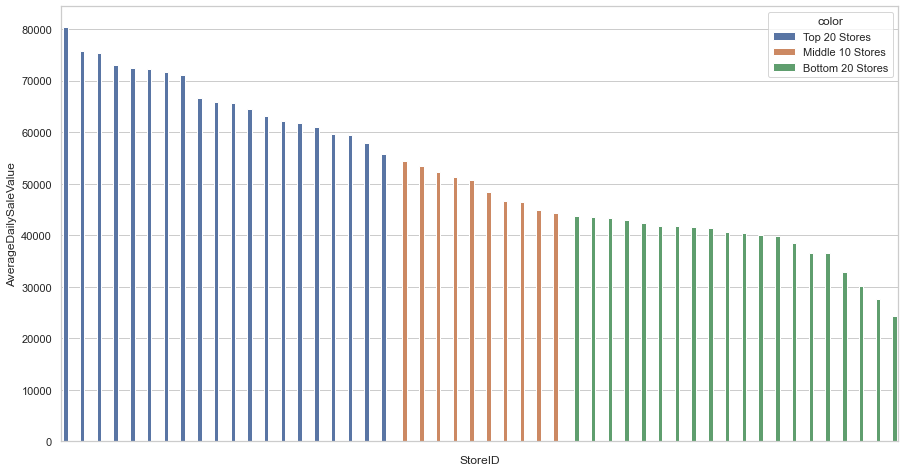

In [404]:
df = data['sales_1'][['SalesDate','StoreID','SalesValue']]

df = df[['SalesDate', 'StoreID','SalesValue']].groupby(
    ['SalesDate', 'StoreID'], as_index=False).agg(
    TotalSaleValue=pd.NamedAgg(column='SalesValue',aggfunc='sum')
).sort_values(by=['StoreID', 'SalesDate'], ascending=False)

df = df[['StoreID','TotalSaleValue']].groupby(
    ['StoreID'], as_index=False).agg(
    AverageDailyTotalSaleValue=pd.NamedAgg(column='TotalSaleValue',aggfunc='mean')
).sort_values(by=['StoreID'], ascending=False)

df = pd.merge(
    df
    , data['AggSalVByStor_D_Mean'].reset_index()[['StoreID', 'StorPerQ']]
    , left_on = 'StoreID', right_on = 'StoreID'
    , how='inner'
)  


plot_order = df.sort_values(by='AverageDailySaleValue', ascending=False).StoreID.values
g = sns.barplot(
    data=df
    x="StoreID", y="AverageDailySaleValue", hue="color",
    ci="sd", order = plot_order
).set(xticklabels=[])



In [15]:
data['AggSalVByStor_D_Mean']

,AverageDailySaleValue,StorPerQ
StoreID,,
1004,80402.249000,10
1027,75779.152000,10
1021,75380.025333,10
1049,72994.614667,10
1035,72441.351667,10
1037,72198.687667,10
1042,71663.743667,10
1034,71082.500000,10
1018,66690.298000,10
